<a href="https://colab.research.google.com/github/miu0001/NweGit/blob/master/6.1%20Descriptive%20Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Union




In [73]:
import pandas as pd

# Dataset from the provided values
values = [
    17.1, 19.3, 18.0, 19.4, 16.5, 14.4, 15.8, 16.6, 18.5, 14.9,
    14.8, 16.3, 20.8, 17.8, 14.8, 15.6, 16.7, 16.1, 17.1, 16.5,
    18.8, 19.3, 18.1, 16.1, 18.0, 17.2, 16.8, 17.3, 14.4, 14.1,
    16.9, 17.6, 15.5, 17.8, 17.2, 17.4, 18.1, 18.4, 17.8, 16.7,
    17.2, 13.7, 18.0, 15.6, 17.8, 17.0, 17.7, 11.9, 15.9, 17.8,
    15.5, 14.6, 15.6, 15.1, 15.4, 16.1, 17.0, 17.1, 19.1, 15.0,
    17.6, 19.7, 17.1, 13.6, 15.6, 16.3, 14.8, 17.4, 14.8, 14.9,
    14.1, 17.8, 19.8, 18.9, 15.6, 16.1, 15.9, 15.7, 22.1, 16.1,
    18.9, 21.5, 17.4, 12.3, 20.2, 14.9, 17.1, 15.0, 14.4, 14.7,
    15.9, 19.0, 16.6, 15.3, 17.7, 15.8
]

# DataFrame named 'df' with a 'price' column (compatible with previous code)
df = pd.DataFrame({"price": values})


In [74]:
import numpy as np
import pandas as pd

# Use the class boundaries 10.95, 11.95, ..., 22.95  (width = 1.0)
edges = np.linspace(10.95, 22.95, 13)  # 13 boundaries → 12 intervals

x = pd.to_numeric(df["price"], errors="coerce").dropna()

# Bin using (a, b] intervals as in the text
cats = pd.cut(x, bins=edges, right=True)

# Frequency and relative frequency
freq = cats.value_counts(sort=False)
n = x.size

rel_freq_table = pd.DataFrame({
    "lower_boundary": edges[:-1],
    "upper_boundary": edges[1:],
    "class_mark": (edges[:-1] + edges[1:]) / 2,
    "frequency": freq.values,
    "relative_frequency": (freq.values / n).round(4)
})

display(rel_freq_table)
print("Sum of relative frequencies:", rel_freq_table["relative_frequency"].sum().round(4))


,lower_boundary,upper_boundary,class_mark,frequency,relative_frequency
0,10.9500,11.9500,11.4500,1,0.0104
1,11.9500,12.9500,12.4500,1,0.0104
2,12.9500,13.9500,13.4500,2,0.0208
3,13.9500,14.9500,14.4500,14,0.1458
4,14.9500,15.9500,15.4500,18,0.1875
5,15.9500,16.9500,16.4500,15,0.1562
6,16.9500,17.9500,17.4500,24,0.2500
7,17.9500,18.9500,18.4500,10,0.1042
8,18.9500,19.9500,19.4500,7,0.0729
9,19.9500,20.9500,20.4500,2,0.0208


Sum of relative frequencies: 0.9998


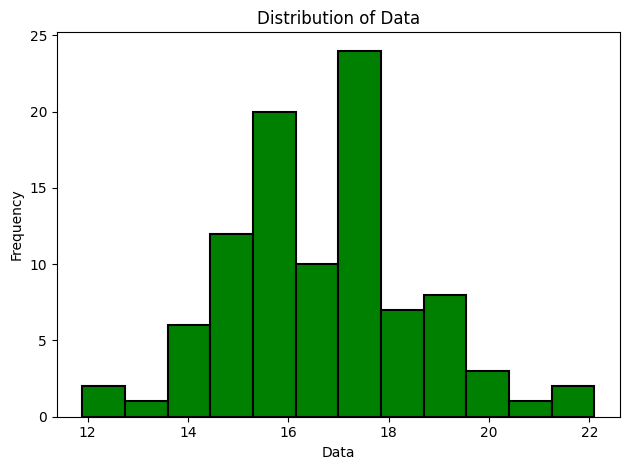

In [75]:
x = df["price"].dropna()

plt.figure()
counts, edges, _ = plt.hist(
    x, bins=12,
    color="green",            # fill color
    edgecolor="black",      # solid boundaries on each bar
    linewidth=1.5
)

# (Optional) draw solid boundary lines up to each bar’s height
for h, left, right in zip(counts, edges[:-1], edges[1:]):
    plt.plot([left, left],   [0, h], color="black", linewidth=1.2)
    plt.plot([right, right], [0, h], color="black", linewidth=1.2)

plt.title("Distribution of Data")
plt.xlabel("Data")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

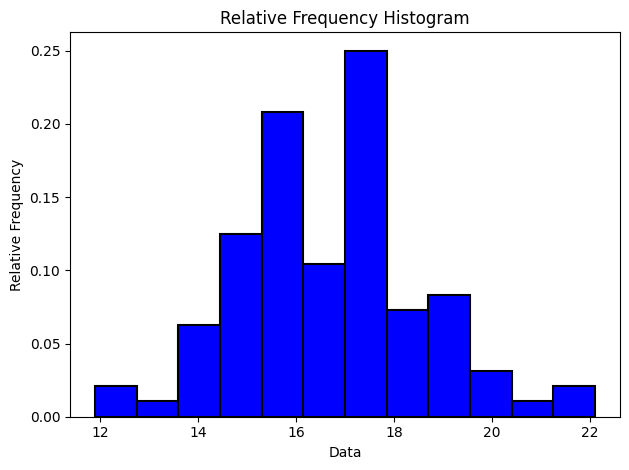

Sum of relative frequencies: 0.9999999999999999


In [76]:
# weights so bar heights are relative frequencies (sum = 1)
weights = np.ones_like(x, dtype=float) / x.size

plt.figure()
counts, edges, _ = plt.hist(
    x, bins=12, weights=weights,   # ← relative frequency
    color="blue",                  # fill color
    edgecolor="black",             # solid boundaries on each bar
    linewidth=1.5
)

# draw solid boundary lines up to each bar’s height
for h, left, right in zip(counts, edges[:-1], edges[1:]):
    plt.plot([left, left],   [0, h], color="black", linewidth=1.2)
    plt.plot([right, right], [0, h], color="black", linewidth=1.2)

plt.title("Relative Frequency Histogram")
plt.xlabel("Data")
plt.ylabel("Relative Frequency")
plt.tight_layout()
plt.show()

# (optional) check: sum of relative frequencies should be ~1
print("Sum of relative frequencies:", counts.sum())

n = 96
x̄ (mean) = 16.7104
s (sample std) = 1.8526
Within 1s: 67 observations (69.79%)
Within 2s: 91 observations (94.79%)


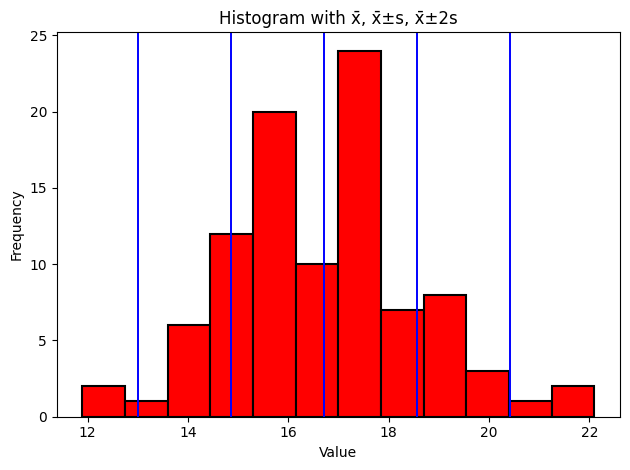

In [77]:
# use your column (here 'price'); change if your column name is different
x = pd.to_numeric(df["price"], errors="coerce").dropna().to_numpy()

# (b) sample mean and sample standard deviation
xbar = x.mean()
s = x.std(ddof=1)  # sample std (ddof=1)

# counts within 1s and 2s
within_1s = ((x >= xbar - s) & (x <= xbar + s)).sum()
within_2s = ((x >= xbar - 2*s) & (x <= xbar + 2*s)).sum()

print(f"n = {x.size}")
print(f"x̄ (mean) = {xbar:.4f}")
print(f"s (sample std) = {s:.4f}")
print(f"Within 1s: {within_1s} observations ({within_1s/x.size:.2%})")
print(f"Within 2s: {within_2s} observations ({within_2s/x.size:.2%})")

# (c) histogram with lines at x̄, x̄±s, x̄±2s
# if you already defined custom bin edges array named `edges`, this will reuse it;
# otherwise it uses 10 bins.
bins = edges if "edges" in globals() else 10

plt.figure()
counts, used_edges, _ = plt.hist(
    x, bins=bins,
    color="red", edgecolor="black", linewidth=1.5
)

for val in [xbar - 2*s, xbar - s, xbar, xbar + s, xbar + 2*s]:
    plt.axvline(val, color="blue", linewidth=1.4)

plt.title("Histogram with x̄, x̄±s, x̄±2s")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [78]:
url = "https://raw.githubusercontent.com/venkatareddykonasani/Datasets/master/kc_house_data/kc_house_data.csv"
df = pd.read_csv(url)
display(df.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,6762700020,20141013T000000,7700000,6,8.0000,12050,27600,2.5000,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.3230,3940,8800
1,9808700762,20140611T000000,7062500,5,4.5000,10040,37325,2.0000,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.2140,3930,25449
2,9208900037,20140919T000000,6885000,6,7.7500,9890,31374,2.0000,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.2400,4540,42730
3,2470100110,20140804T000000,5570000,5,5.7500,9200,35069,2.0000,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.2330,3560,24345
4,8907500070,20150413T000000,5350000,5,5.0000,8000,23985,2.0000,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.2200,4600,21750


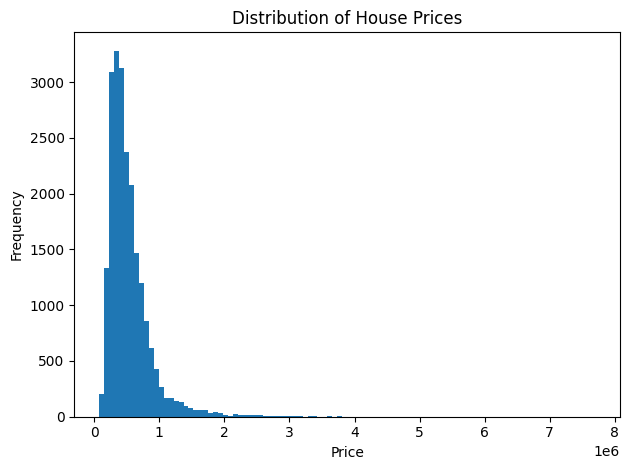

In [79]:
plt.figure()
plt.hist(df["price"].dropna(), bins=100)  # adjust bins as you like (e.g., 30, 50)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

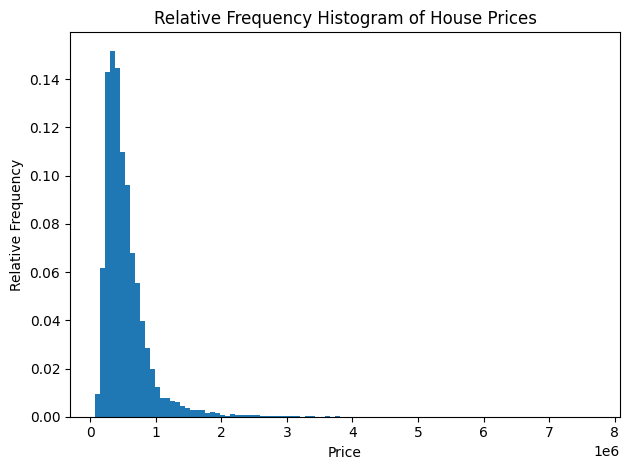

In [80]:
# Relative-frequency histogram (heights = proportion in each bin)
x = df["price"].dropna().to_numpy()
weights = np.ones_like(x) / x.size

plt.figure()
plt.hist(x, bins=100, weights=weights)   # equal-width bins → bar height = relative frequency
plt.title("Relative Frequency Histogram of House Prices")
plt.xlabel("Price")
plt.ylabel("Relative Frequency")
plt.tight_layout()
plt.show()

In [81]:
# DataFrame of the provided weights
weights = [
    3.968, 3.534, 4.032, 3.912, 3.572, 4.014, 3.682, 3.608,
    3.669, 3.705, 4.023, 3.588, 3.945, 3.871, 3.744, 3.711,
    3.645, 3.977, 3.888, 3.948, 3.551, 3.796, 3.657, 3.667,
    3.799, 4.010, 3.704, 3.642, 3.681, 3.554, 4.025, 4.079,
    3.621, 3.575, 3.714, 4.017, 4.082, 3.660, 3.692, 3.905,
    3.977, 3.961, 3.948, 3.994, 3.958, 3.860, 3.965, 3.592,
    3.681, 3.861, 3.662, 3.998, 4.010, 3.999, 3.993, 4.004,
    3.704, 4.008, 4.027, 3.970, 3.647, 3.847, 3.628, 3.646,
    3.674, 3.402, 3.409, 3.609, 3.619, 4.009, 3.405, 3.615,
    3.672, 3.898, 3.959, 3.607, 3.707, 3.978, 3.656, 4.027,
    3.645, 3.643, 3.898, 3.635, 3.865, 3.631, 3.929, 3.635,
    3.511, 3.539, 3.830, 3.925, 3.971, 3.646, 3.669, 3.931,
    4.028, 3.665, 3.681, 3.984, 3.664, 3.893, 3.606, 3.699,
    3.997, 3.936, 3.976, 3.627, 3.536, 3.695, 3.981, 3.587,
    3.810, 3.888, 3.921, 3.953, 3.847, 3.645, 4.042, 3.692,
    3.910, 3.672, 3.957, 3.958, 3.950, 3.904, 3.928, 3.984,
    3.721, 3.927, 3.621, 4.038, 4.047, 3.627, 3.774, 3.983,
    3.658, 4.034, 3.778
]

df = pd.DataFrame({"weight": weights})